Insert notebook description here

In [12]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
from flopy.utils.gridintersect import GridIntersect
from shapely.geometry import Point
plt.rcParams['font.size']=12

In [13]:
bins_pth = os.path.join('..', 'bins', 'win') if 'nt' in os.name else os.path.join('..', 'bins', 'linux') # Binaries
observations_pth = os.path.join("..", "data", "observations") # Measured data (field obs)
org_model_ws = os.path.join('..', 'base_model_files') # Exported from ModelMuse
os.listdir(org_model_ws)

['hagfors.dis',
 'hagfors.dis.grb',
 'hagfors.ghb',
 'hagfors.ic',
 'hagfors.ims',
 'hagfors.nam',
 'hagfors.npf',
 'hagfors.oc',
 'hagfors.sfr',
 'hagfors.tdis',
 'mfsim.lst',
 'mfsim.nam']

Copy files to new working dir:

In [14]:
tmp_model_ws = os.path.join('..', 'hagfors_flopy_prep')
if os.path.exists(tmp_model_ws):
    shutil.rmtree(tmp_model_ws)
shutil.copytree(org_model_ws,tmp_model_ws)
os.listdir(tmp_model_ws)

['hagfors.dis',
 'hagfors.dis.grb',
 'hagfors.ghb',
 'hagfors.ic',
 'hagfors.ims',
 'hagfors.nam',
 'hagfors.npf',
 'hagfors.oc',
 'hagfors.sfr',
 'hagfors.tdis',
 'mfsim.lst',
 'mfsim.nam']

Load model:

In [15]:
sim_name = 'hagfors'
sim = flopy.mf6.MFSimulation.load(sim_name, 'mf6', os.path.join(bins_pth, 'mf6'), tmp_model_ws)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package oc...
    loading package ghb...
    loading package sfr...
  loading ims package hagfors...


In [16]:
# Get model object
m = sim.get_model('hagfors')

Reset IMS & TDIS packages:

In [17]:
ims = sim.ims
sim.remove_package(ims)
ims = flopy.mf6.ModflowIms( # The following settings allow SFR to converge (default settings won't)
    sim,                    # Settings could possibly be tuned to allow faster convergence though.
    pname='hagfors.ims',
    print_option='SUMMARY',
    complexity='SIMPLE',
    outer_dvclose = 1e-2,
    outer_maximum = 750,
    inner_maximum = 50,
    linear_acceleration = 'bicgstab'  
)
sim.register_ims_package(ims, ['hagfors'])

start_date_time is the date representing data used for in previous modeling study. Doing a fast steadystate using the same data allow for a quick demonstration of difference in structural complexity (16 layers) vs a highly parameterized approach:

In [18]:
tdis = sim.tdis
sim.remove_package(tdis)

tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
    sim,
    pname='hagfors.tdis',
    time_units='DAYS',
    start_date_time = '17-06-2016',
    nper=1,
    perioddata=[(1.0, 1, 1.0)]
)

Adding recharge:

In [19]:
recharge_initial_guess = 200 / 1000 / 365 # 200mm/year ≈ 5.48e-4 m/day

rch = flopy.mf6.ModflowGwfrcha(
    model = m,
    pname = 'rch',
    recharge = recharge_initial_guess,
    save_flows = True, # Is this necessary?
)

Assigning initial conditions:

In [20]:
ic = m.get_package('ic') # Get IC package
ic.strt = 138 # Set initial heads to 138 masl

Load the SFR-package:

In [21]:
sfr = m.get_package('sfr')

Plot the streambed elevation (elevation sampled from digital elevation map):

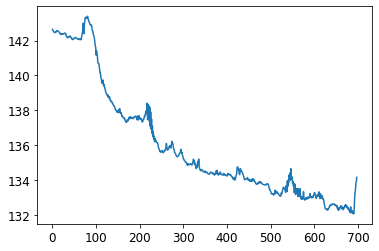

In [22]:
plt.plot(sfr.packagedata.array.rtp)

Streambed elevation is not allowed to increase in the downstream direction. Because of this, let's smoothen the elevation similar to how it's done using the SFRmaker package:

In [23]:
# This can probably be handled with more grace, but it gets the job done
smoothed_sfr_elevation = []
current_min = 0
for count, element in enumerate(sfr.packagedata.array.rtp):
    if count == 0:
        smoothed_sfr_elevation.append(element)
        current_min = element
    else:
        if element > current_min:
            new_min = current_min - 0.0001
            smoothed_sfr_elevation.append(new_min)
            current_min = new_min
        else:
            smoothed_sfr_elevation.append(element)
            current_min = element

Plot the original streambed elevation (blue) and smoothened streambed elevation (orange):

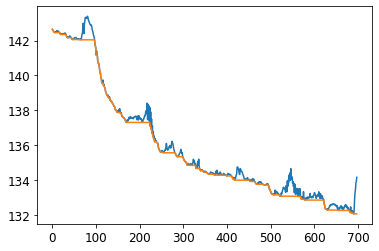

In [24]:
plt.plot(sfr.packagedata.array.rtp)
plt.plot(smoothed_sfr_elevation)

Replace streambeds with smoothed version:

In [25]:
sfr.packagedata.array.rtp = np.array(smoothed_sfr_elevation)

## Setup model-output observations (computed values)

In [26]:
ix = GridIntersect(m.modelgrid)

### SFR observations
These are the cells representing locations where field measured data is collected (stage and streamflow):

In [27]:
sfrobs = pd.read_excel(os.path.join(observations_pth, 'obs_flow_and_stage.xlsx'))
sfrobs['shapely_point'] = [Point(row['POINT_X'], row['POINT_Y']) for index, row in sfrobs.iterrows()]
sfrobs['row_col'] = [ix.intersect(i).cellids[0] for i in sfrobs['shapely_point']]
sfrobs[['row', 'col']] = pd.DataFrame(sfrobs['row_col'].tolist(), index=sfrobs.index)
display(sfrobs)

,NAME,POINT_X,POINT_Y,TYPE,shapely_point,row_col,row,col
0,NI15-O1-STG,427391.988166,6.654917e+06,STAGE,POINT (427391.988166 6654917.31795),"(170, 220)",170,220
1,NI15-O44-STG,427385.272148,6.654938e+06,STAGE,POINT (427385.272148 6654938.18864),"(160, 225)",160,225
2,NI15-O46-STG,427316.293421,6.655000e+06,STAGE,POINT (427316.293421 6655000.15848),"(114, 222)",114,222
3,NI15-O47-STG,427294.946661,6.654962e+06,STAGE,POINT (427294.946661 6654962.31574),"(120, 202)",120,202
4,NI15-O48-STG,427166.670722,6.654947e+06,STAGE,POINT (427166.670722 6654946.6169),"(80, 151)",80,151
5,GAGE-1,427030.760000,6.654934e+06,INFLOW,POINT (427030.76 6654934.26),"(36, 98)",36,98


In [28]:
sfr_pkgdata = pd.DataFrame(sfr.packagedata.get_data())
sfr_pkgdata[['layer', 'row', 'col']] = pd.DataFrame(sfr_pkgdata['cellid'].tolist(), index=sfr_pkgdata.index)
display(sfr_pkgdata)

,rno,cellid,rlen,rwid,rgrd,rtp,rbth,rhk,man,ncon,ustrf,ndv,boundname,layer,row,col
0,0,"(0, 176, 379)",1.768878,2.0,0.001,142.6419,1.0,86.4,3.000000000000e-002,1,1.0,0,orbacken_sfr_1,0,176,379
1,1,"(0, 176, 378)",2.273218,2.0,0.001,142.5888,1.0,86.4,3.000000000000e-002,2,1.0,0,orbacken_sfr_1,0,176,378
2,2,"(0, 176, 377)",0.069087,2.0,0.001,142.5533,1.0,86.4,3.000000000000e-002,2,1.0,0,orbacken_sfr_1,0,176,377
3,3,"(0, 175, 377)",2.204131,2.0,0.001,142.5138,1.0,86.4,3.000000000000e-002,2,1.0,0,orbacken_sfr_1,0,175,377
4,4,"(0, 175, 376)",2.062961,2.0,0.001,142.4699,1.0,86.4,3.000000000000e-002,2,1.0,0,orbacken_sfr_1,0,175,376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,693,"(0, 2, 60)",1.439392,2.0,0.001,132.0557,1.0,86.4,3.000000000000e-002,2,1.0,0,orbacken_sfr_13,0,2,60
694,694,"(0, 1, 60)",1.266846,2.0,0.001,132.0556,1.0,86.4,3.000000000000e-002,2,1.0,0,orbacken_sfr_13,0,1,60
695,695,"(0, 1, 59)",1.701972,2.0,0.001,132.0555,1.0,86.4,3.000000000000e-002,2,1.0,0,orbacken_sfr_13,0,1,59
696,696,"(0, 0, 59)",1.004265,2.0,0.001,132.0554,1.0,86.4,3.000000000000e-002,2,1.0,0,orbacken_sfr_13,0,0,59


In [29]:
merged_sfr_obs = pd.merge(sfrobs, sfr_pkgdata, on=['row', 'col'], how='inner')
display(merged_sfr_obs)

,NAME,POINT_X,POINT_Y,TYPE,shapely_point,row_col,row,col,rno,cellid,...,rgrd,rtp,rbth,rhk,man,ncon,ustrf,ndv,boundname,layer
0,NI15-O1-STG,427391.988166,6.654917e+06,STAGE,POINT (427391.988166 6654917.31795),"(170, 220)",170,220,264,"(0, 170, 220)",...,0.001,135.5608,1.0,86.4,3.000000000000e-002,2,1.0,0,orbacken_sfr_6,0
1,NI15-O44-STG,427385.272148,6.654938e+06,STAGE,POINT (427385.272148 6654938.18864),"(160, 225)",160,225,280,"(0, 160, 225)",...,0.001,135.5592,1.0,86.4,3.000000000000e-002,2,1.0,0,orbacken_sfr_7,0
2,NI15-O46-STG,427316.293421,6.655000e+06,STAGE,POINT (427316.293421 6655000.15848),"(114, 222)",114,222,376,"(0, 114, 222)",...,0.001,134.2803,1.0,86.4,3.000000000000e-002,2,1.0,0,orbacken_sfr_8,0
3,NI15-O47-STG,427294.946661,6.654962e+06,STAGE,POINT (427294.946661 6654962.31574),"(120, 202)",120,202,415,"(0, 120, 202)",...,0.001,134.0639,1.0,86.4,3.000000000000e-002,2,1.0,0,orbacken_sfr_9,0
4,NI15-O48-STG,427166.670722,6.654947e+06,STAGE,POINT (427166.670722 6654946.6169),"(80, 151)",80,151,522,"(0, 80, 151)",...,0.001,133.0733,1.0,86.4,3.000000000000e-002,2,1.0,0,orbacken_sfr_11,0
5,GAGE-1,427030.760000,6.654934e+06,INFLOW,POINT (427030.76 6654934.26),"(36, 98)",36,98,620,"(0, 36, 98)",...,0.001,132.8466,1.0,86.4,3.000000000000e-002,2,1.0,0,orbacken_sfr_12,0


Extract reach number for corresponding SFR observation:

In [30]:
sfrobs_input = [(row['NAME'], row['TYPE'], row['rno']) for index, row in merged_sfr_obs.iterrows()]
sfrobs_input

[('NI15-O1-STG', 'STAGE', 264),
 ('NI15-O44-STG', 'STAGE', 280),
 ('NI15-O46-STG', 'STAGE', 376),
 ('NI15-O47-STG', 'STAGE', 415),
 ('NI15-O48-STG', 'STAGE', 522),
 ('GAGE-1', 'INFLOW', 620)]

Initialize SFR observations:

In [31]:
sfr_obs_recarray = {'{}.obs.csv'.format('sfr'): sfrobs_input}
sfr.obs.initialize(
    filename = '{}.sfr.obs'.format(sim_name),
    digits = 10,
    print_input = True,
    continuous = sfr_obs_recarray
)

### Head observations
These are the locations where field measured data is collected (head) using piezometers and manual measurements:

In [32]:
headobs = pd.read_excel(os.path.join(observations_pth, 'obs_head_per_layer.xlsx'))
headobs['shapely_point'] = [Point(row['POINT_X'], row['POINT_Y']) for index, row in headobs.iterrows()]
headobs['row_col'] = [ix.intersect(i).cellids[0] for i in headobs['shapely_point']]
headobs[['row', 'col']] = pd.DataFrame(headobs['row_col'].tolist(), index=headobs.index)
display(headobs)

,NAME,POINT_X,POINT_Y,LAYER,shapely_point,row_col,row,col
0,B9-2,426918.374000,6.654803e+06,1,POINT (426918.374 6654803.298),"(43, 12)",43,12
1,B10-2,427074.709423,6.654805e+06,1,POINT (427074.709423 6654805.17421),"(97, 68)",97,68
2,B12-1,427448.188505,6.655156e+06,1,POINT (427448.188505 6655156.014),"(105, 324)",105,324
3,B16-1,427409.547301,6.655023e+06,1,POINT (427409.547301 6655023.27117),"(139, 264)",139,264
4,B2-1,427384.172044,6.655037e+06,1,POINT (427384.172044 6655037.1887),"(125, 260)",125,260
...,...,...,...,...,...,...,...,...
139,NI1705-2,427215.444386,6.654958e+06,3,POINT (427215.444386 6654957.96958),"(93, 172)",93,172
140,NI1706-2,427250.038227,6.654940e+06,3,POINT (427250.038227 6654940.18623),"(112, 178)",112,178
141,NI1707-1,427229.096032,6.654943e+06,3,POINT (427229.096032 6654942.66111),"(103, 171)",103,171
142,NI1708-1,427447.873358,6.654978e+06,3,POINT (427447.873358 6654977.69539),"(168, 261)",168,261


In [33]:
headobs_input = [(row['NAME'], 'HEAD', (row['LAYER'] - 1, row['row'], row['col']), (row['LAYER'] - 1, row['row'], row['col'] + 1)) for index, row in headobs.iterrows()]
headobs_input

[('B9-2', 'HEAD', (0, 43, 12), (0, 43, 13)),
 ('B10-2', 'HEAD', (0, 97, 68), (0, 97, 69)),
 ('B12-1', 'HEAD', (0, 105, 324), (0, 105, 325)),
 ('B16-1', 'HEAD', (0, 139, 264), (0, 139, 265)),
 ('B2-1', 'HEAD', (0, 125, 260), (0, 125, 261)),
 ('B22-1', 'HEAD', (0, 110, 320), (0, 110, 321)),
 ('B27', 'HEAD', (0, 106, 329), (0, 106, 330)),
 ('B29', 'HEAD', (0, 115, 263), (0, 115, 264)),
 ('KB1-1', 'HEAD', (0, 165, 235), (0, 165, 236)),
 ('KB4-3', 'HEAD', (0, 98, 177), (0, 98, 178)),
 ('NI1301-1', 'HEAD', (0, 111, 328), (0, 111, 329)),
 ('NI1302-1', 'HEAD', (0, 108, 324), (0, 108, 325)),
 ('NI1403-1', 'HEAD', (0, 164, 281), (0, 164, 282)),
 ('NI1405-1', 'HEAD', (0, 156, 289), (0, 156, 290)),
 ('NI1407-1', 'HEAD', (0, 111, 310), (0, 111, 311)),
 ('NI1408-1', 'HEAD', (0, 105, 310), (0, 105, 311)),
 ('NI1409-1', 'HEAD', (0, 121, 310), (0, 121, 311)),
 ('NI1410-1', 'HEAD', (0, 120, 320), (0, 120, 321)),
 ('NI1411-1', 'HEAD', (0, 115, 326), (0, 115, 327)),
 ('NI1412-1', 'HEAD', (0, 164, 277), (0

Initialize head observations:

In [34]:
# observations
obs_recarray = {'{}.obs.csv'.format('head'): headobs_input}
obs = flopy.mf6.ModflowUtlobs(
    m,
    pname = 'gwf_obs',
    filename = '{}.obs'.format(sim_name),
    digits = 10,
    print_input = True,
    continuous = obs_recarray
)

## Last preparations

In [35]:
sim.simulation_data.max_columns_of_data = m.dis.ncol # Is this required to get the model to play nice with PyEMU?

Set all data external (required by PEST):

In [36]:
sim.set_all_data_external(True)

In [37]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package hagfors.ims...
  writing model hagfors...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package oc...
    writing package ghb_0...
    writing package sfr_0...
    writing package rch...
    writing package obs_0...
    writing package gwf_obs...


Run the simulation:

In [38]:
success, buff = sim.run_simulation(report=True)
print('\nSuccess is: ', success)

FloPy is using the following  executable to run the model: ..\bins\win\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 21:14:51 with IFORT compiler (ver. 19.10.3)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources S

Model run time is really slow (47 seconds on my laptop), likely due to a combination of a small cell-size and large SFR-input. Change starting heads to simulated output to speed up future sims..:

In [39]:
# Read computed head
fname = os.path.join(tmp_model_ws, 'hagfors.bhd')
hds = flopy.utils.binaryfile.HeadFile(fname)

Replace IC with computed head:

In [40]:
ic.strt = hds.get_data()

Re-write sim files:

In [41]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package hagfors.ims...
  writing model hagfors...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package oc...
    writing package ghb_0...
    writing package sfr_0...
    writing package rch...
    writing package obs_0...
    writing package gwf_obs...


Re-run model:

In [42]:
success, buff = sim.run_simulation(report=True)
print('\nSuccess is: ', success)

FloPy is using the following  executable to run the model: ..\bins\win\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 21:14:51 with IFORT compiler (ver. 19.10.3)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources S

A bit faster.  

Plot results:

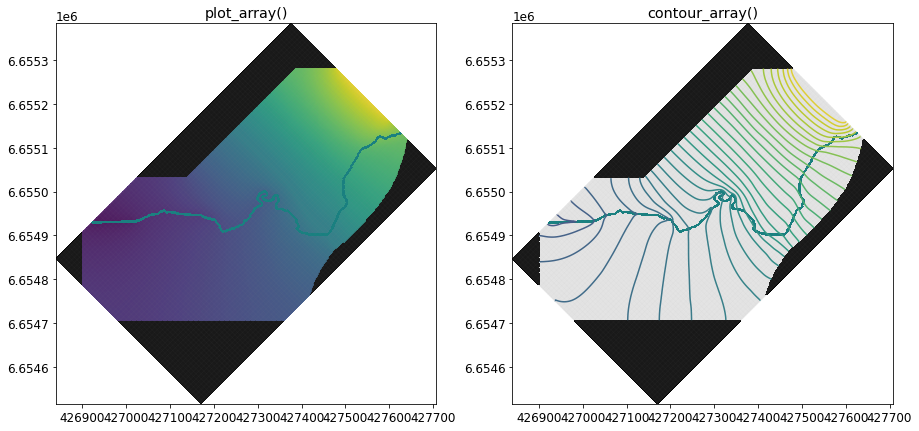

In [43]:
fname = os.path.join(tmp_model_ws, 'hagfors.bhd')
hdobj = flopy.utils.HeadFile(fname)
head = hdobj.get_data()
levels = np.arange(130, 140, .25)
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(1, 2, 1, aspect='equal')
ax.set_title('plot_array()')
mapview = flopy.plot.PlotMapView(model=m)
quadmesh = mapview.plot_ibound()
quadmesh = mapview.plot_array(head, masked_values=[1e30], alpha=0.5)
mapview.plot_bc("SFR")
linecollection = mapview.plot_grid(lw=0.1)

ax = fig.add_subplot(1, 2, 2, aspect='equal')
ax.set_title('contour_array()')
mapview = flopy.plot.PlotMapView(model=m)
quadmesh = mapview.plot_ibound()
mapview.plot_bc("SFR")
contour_set = mapview.contour_array(head, masked_values=[1e30], levels=levels)
linecollection = mapview.plot_grid(lw=0.1);